In [15]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import torch
from torch.utils.data import DataLoader, TensorDataset
import lightning as L
import torch.nn.functional as F
import optuna
import tensorboard
from lightning.pytorch.loggers import TensorBoardLogger

import warnings
warnings.filterwarnings("ignore")
from importlib import reload

# this ensures that I can update the class without losing my variables in my notebook
import xenium_cluster
reload(xenium_cluster)
from xenium_cluster import XeniumCluster
from utils.metrics import *

from sklearn.decomposition import PCA

In [16]:
# Path to your .gz file
file_path = 'data/hBreast/transcripts.csv.gz'

# Read the gzipped CSV file into a DataFrame
df_transcripts = pd.read_csv(file_path, compression='gzip')
df_transcripts.head(), df_transcripts.shape

(     transcript_id  cell_id  overlaps_nucleus feature_name  x_location  \
 0  281474976710657   191815                 1          LUM   4797.2383   
 1  281474976710663   214084                 1       SEC11C   4801.7330   
 2  281474976710672   191342                 0         TCIM   4804.4920   
 3  281474976710673   191574                 0         STC1   4805.0483   
 4  281474976710674   192193                 0         STC1   4805.7170   
 
    y_location  z_location         qv  
 0   550.61346   15.421524  18.445875  
 1   905.11600   14.925031  31.019386  
 2   596.05396   14.681485  22.270780  
 3   414.38370   19.306356  16.183300  
 4   273.81440   16.112896  26.251837  ,
 (43775350, 8))

In [17]:
df_transcripts = df_transcripts[~df_transcripts["feature_name"].str.startswith('BLANK_') & ~df_transcripts["feature_name"].str.startswith('NegControl')]

In [18]:
# drop cells without ids
df_transcripts = df_transcripts[df_transcripts["cell_id"] != -1]

In [19]:
random_rows = df_transcripts.sample(n=10000, random_state=1)  # random_state is used for reproducibility

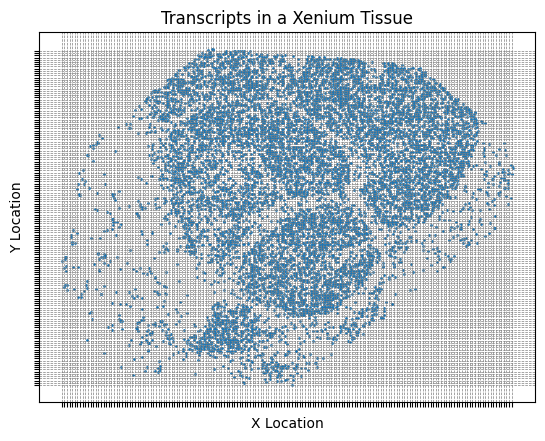

In [20]:
plt.scatter(random_rows["x_location"], random_rows["y_location"], s=1)
plt.xlabel('X Location')
plt.ylabel('Y Location')
plt.title('Transcripts in a Xenium Tissue')


k = 55
plt.xticks(range(int(random_rows["x_location"].min()), int(random_rows["x_location"].max()) + 1, k), labels=[])
plt.yticks(range(int(random_rows["y_location"].min()), int(random_rows["y_location"].max()) + 1, k), labels=[])

plt.grid(True, which='both', color='gray', linewidth=0.5, linestyle='--')

plt.show()

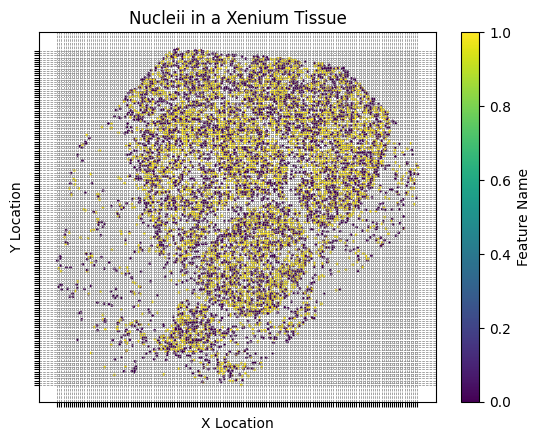

In [21]:
plt.scatter(random_rows["x_location"], random_rows["y_location"], s=1, c=random_rows["overlaps_nucleus"], cmap='viridis')
plt.colorbar(label='Feature Name')  # Adds a colorbar with labels to the plot
plt.xlabel('X Location')
plt.ylabel('Y Location')
plt.title('Nucleii in a Xenium Tissue')


k = 55
plt.xticks(range(int(random_rows["x_location"].min()), int(random_rows["x_location"].max()) + 1, k), labels=[])
plt.yticks(range(int(random_rows["y_location"].min()), int(random_rows["y_location"].max()) + 1, k), labels=[])

plt.grid(True, which='both', color='gray', linewidth=0.5, linestyle='--')

plt.show()

# EDA on Spot Data

For now, we will focus on the 2D case and ignore the 3D information.

In [22]:
clustering = XeniumCluster(data=df_transcripts, dataset_name="hBreast")
clustering.set_spot_size(50)
clustering.create_spot_data(third_dim=False, save_data=True)

In [23]:
valid_genes_mask = ~clustering.xenium_spot_data.var_names.str.startswith('BLANK_') & ~clustering.xenium_spot_data.var_names.str.startswith('NegControl')
clustering.xenium_spot_data = clustering.xenium_spot_data[:, valid_genes_mask]

In [24]:
clustering.normalize_counts(clustering.xenium_spot_data)

In [25]:
clustering.xenium_spot_data.obs

,spot_number,x_location,y_location,z_location,row,col
0,43,548.426080,2218.907850,12.599341,43.0,0.0
1,45,550.663970,2337.095433,19.034785,45.0,0.0
2,46,552.062194,2358.384500,16.009149,46.0,0.0
3,47,551.965956,2423.005319,16.599941,47.0,0.0
4,48,546.802622,2483.570972,15.898581,48.0,0.0
...,...,...,...,...,...,...
23439,33366,10015.713547,5868.944360,27.402354,116.0,190.0
23440,33367,10018.078500,5910.929274,27.193971,117.0,190.0
23441,33368,10017.667292,5977.355553,27.780879,118.0,190.0
23442,33369,10015.040000,6039.822000,30.913712,119.0,190.0


## PCA + Spatial EDA

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# n_pcs = 10
# output_spatial_norm_prop = 0.00

# sc.tl.pca(clustering.xenium_spot_data, svd_solver='arpack', n_comps=n_pcs)
# gene_data = clustering.xenium_spot_data.obsm["X_pca"]
# spatial_locations = clustering.xenium_spot_data.obs[["row", "col"]]
# data = np.concatenate((spatial_locations, gene_data), axis=1)
# spatial_normalize = (n_pcs * output_spatial_norm_prop / (2 - 2 * output_spatial_norm_prop)) ** 0.5
# variances = data.var(axis=0)
# print(variances)
# print("Spatial Variance Proportion: ", sum(variances[:2])/sum(variances))
# data = StandardScaler().fit_transform(data)
# data[:, :spatial_locations.shape[1]] *= spatial_normalize
# standardizes_variances = data.var(axis=0)
# print(standardizes_variances)
# print("Spatial Variance Proportion After Standardization: ", sum(standardizes_variances[:2])/sum(standardizes_variances))

# All Genes vs. PCA K-Means Analysis

Starting Moran's I Calculation.
Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 1.3471316096603716
100 CEACAM6 0.38134072677926306
100 FASN 1.1089009143317885
100 FGL2 0.6433495778489113
100 IL7R 1.1566561834781546
100 KRT6B 0.8868047137557985
100 POSTN 0.512260530738435
100 TCIM 0.3945688219774315
Starting Moran's I Calculation.
Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 1.428717742091913
100 CEACAM6 0.39059005143411646
100 FASN 1.1077100986274175
100 FGL2 0.654113047343285
100 IL7R 1.233255812871672
100 KRT6B 0.9314304833550495
100 POSTN 0.5149868714761288
100 TCIM 0.46651883372110536


{'ABCC11': 0.8571616555953429,
 'ACTA2': 0.8035216651978955,
 'ACTG2': 0.9805390186560474,
 'ADAM9': 0.7287637112350641,
 'ADGRE5': 0.6682017385015966,
 'ADH1B': 0.44026135165993396,
 'ADIPOQ': 0.4104513337333089,
 'AGR3': 0.3906130592784848,
 'AIF1': 0.6360699393031656,
 'AKR1C1': 0.2880091937880293,
 'AKR1C3': 0.23492878262819955,
 'ALDH1A3': 0.31963900011575835,
 'ANGPT2': 0.26749348171876786,
 'ANKRD28': 0.8180464169765493,
 'ANKRD29': 0.3138378732918073,
 'ANKRD30A': 1.010544347767063,
 'APOBEC3A': 0.1418250876365276,
 'APOBEC3B': 0.4082806425293671,
 'APOC1': 0.6282454804930129,
 'AQP1': 0.42627402500736417,
 'AQP3': 0.2795145357957887,
 'AR': 0.963442867839601,
 'AVPR1A': 0.16473108352405025,
 'BACE2': 0.4938857793267434,
 'BANK1': 1.428717742091913,
 'BASP1': 0.6003165860068524,
 'C15orf48': 0.354302870917333,
 'C1QA': 0.2797381607538651,
 'C1QC': 0.37421537540688127,
 'C2orf42': 0.36536859616422995,
 'C5orf46': 0.32991102612635376,
 'C6orf132': 0.702875909727411,
 'CAV1': 0.48

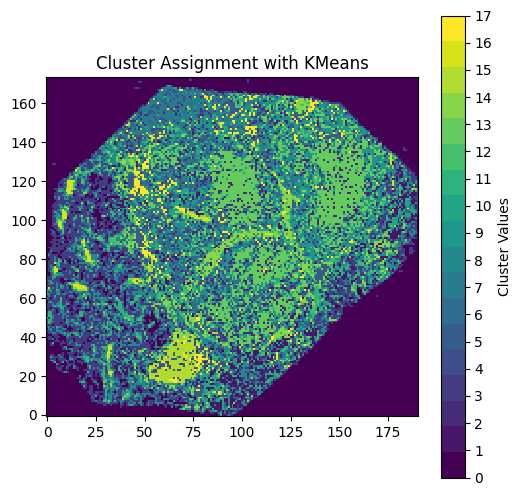

In [27]:
num_clusters = 17
n_pcs = 25
sc.tl.pca(clustering.xenium_spot_data, svd_solver='arpack', n_comps=n_pcs)
gene_data = clustering.xenium_spot_data.X
spatial_locations = clustering.xenium_spot_data.obs[["row", "col"]]
data = np.concatenate((spatial_locations, gene_data), axis=1)
data = StandardScaler().fit_transform(data)

kmeans = KMeans(n_clusters=num_clusters).fit(data)

initial_clusters = kmeans.predict(data)

rows = spatial_locations["row"].astype(int)
columns = spatial_locations["col"].astype(int)

num_rows = max(rows) + 1
num_cols = max(columns) + 1

cluster_grid = torch.zeros((num_rows, num_cols), dtype=torch.int)

cluster_grid[rows, columns] = torch.tensor(initial_clusters) + 1

colors = plt.cm.get_cmap('viridis', num_clusters + 1)
colormap = ListedColormap(colors(np.linspace(0, 1, num_clusters + 1)))

plt.figure(figsize=(6, 6))
plt.imshow(cluster_grid.cpu(), cmap=colormap, interpolation='nearest', origin='lower')
plt.colorbar(ticks=range(num_clusters + 1), label='Cluster Values')
plt.title('Cluster Assignment with KMeans')

clustering_without_norms = XeniumCluster(data=df_transcripts, dataset_name="hBreast")
clustering_without_norms.set_spot_size(50)
clustering_without_norms.create_spot_data(third_dim=False, save_data=True)

gene_morans_i(clustering_without_norms, spatial_locations, pd.DataFrame(initial_clusters).iloc[:, 0])

clusters = pd.read_csv("results/hBreast/K-Means/17/clusters/50/clusters_K=17.csv")["K-Means cluster"]

gene_morans_i(clustering_without_norms, spatial_locations, clusters)

### PCA on Unfiltered Spot Data

In [28]:
sc.tl.pca(clustering.xenium_spot_data, svd_solver='arpack', n_comps=5)
clustering.xenium_spot_data.obsm["X_pca"]

array([[18.83696   , -6.2902703 , -0.18928863,  1.8653791 , -0.99922854],
       [18.26319   , -4.579379  , -0.05126271,  0.24942821, -0.11098397],
       [17.34093   , -3.010292  ,  0.20495394, -1.2442    ,  0.63186187],
       ...,
       [17.400406  , -4.136654  , -2.009559  ,  3.5954752 , -2.6160274 ],
       [18.806004  , -6.4084907 , -0.19967207,  1.8457401 , -0.9760097 ],
       [18.591854  , -5.6324925 , -0.54454917,  1.0690219 , -1.0546656 ]],
      dtype=float32)

In [29]:
clustering.xenium_spot_data.varm["PCs"]
clustering.xenium_spot_data.varm["PCs"]

array([[-0.08499513, -0.07144938,  0.01490355,  0.01972404,  0.04390629],
       [-0.06406355,  0.11267729,  0.04338603, -0.05959638,  0.06724564],
       [-0.05849016,  0.03047039,  0.02343906,  0.01808151,  0.05067626],
       ...,
       [-0.02269711,  0.10721383,  0.05193341, -0.04511489, -0.02641639],
       [-0.01950392,  0.14866414,  0.01508957,  0.01427186, -0.0368025 ],
       [-0.08455068,  0.00222306,  0.01093216,  0.01555828,  0.01004685]])

In [30]:
data = np.save('PC.npy', clustering.xenium_spot_data.varm["PCs"])

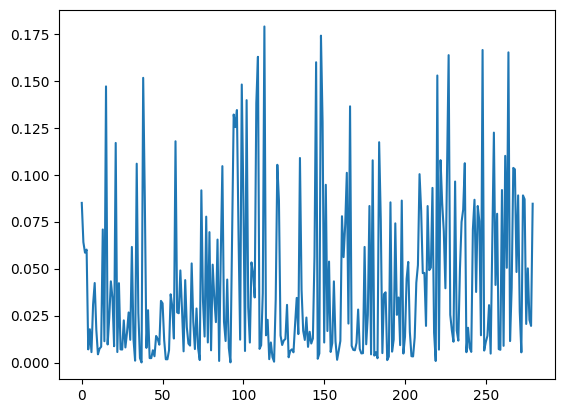

In [31]:
plt.plot(np.abs(clustering.xenium_spot_data.varm["PCs"][:, 0]))

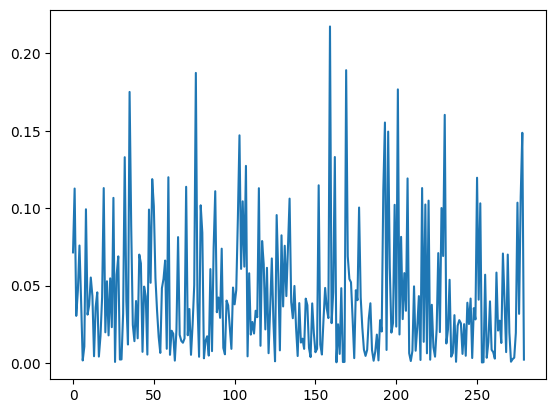

In [32]:
plt.plot(np.abs(clustering.xenium_spot_data.varm["PCs"][:, 1]))

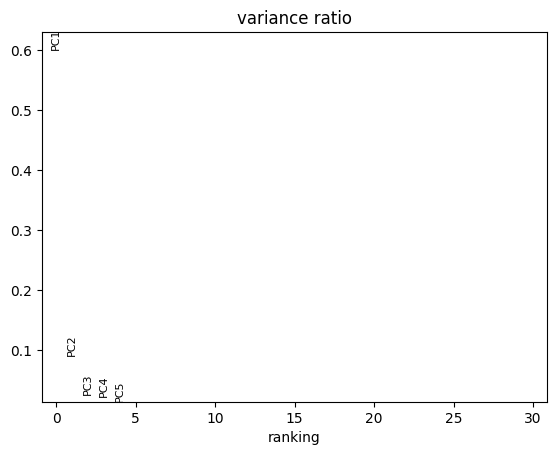

<Figure size 640x480 with 0 Axes>

In [33]:
sc.pl.pca_variance_ratio(clustering.xenium_spot_data)
plt.savefig("results/EDA/spotPCA.png")

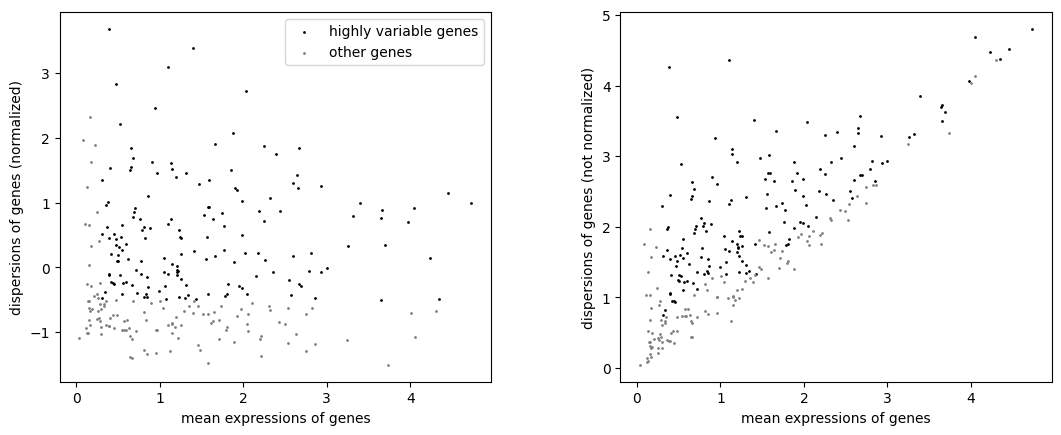

In [34]:
clustering.filter_only_high_variable_genes(clustering.xenium_spot_data, plot_highly_variable_genes=True)

### PCA on Highly-Variable Spot Data

In [35]:
clustering.xenium_spot_data = clustering.xenium_spot_data[:,clustering.xenium_spot_data.var.highly_variable==True]

sc.tl.pca(clustering.xenium_spot_data, svd_solver='arpack')
clustering.xenium_spot_data.obsm["X_pca"]

array([[ 1.43629599e+01, -6.21055365e+00,  5.20639420e-01, ...,
         1.21520855e-01,  2.25001518e-02,  1.81137234e-01],
       [ 1.42330542e+01, -4.40733147e+00,  3.49296667e-02, ...,
         1.49174243e-01, -2.42200211e-01, -8.25674832e-02],
       [ 1.34775229e+01, -2.90461636e+00, -3.25828999e-01, ...,
         4.65890259e-01, -4.66511458e-01, -2.94388264e-01],
       ...,
       [ 1.32550478e+01, -4.53218174e+00, -2.64141440e-01, ...,
        -1.40104787e-02,  1.72951952e-01,  2.56581251e-02],
       [ 1.43787365e+01, -6.31966877e+00,  5.08173525e-01, ...,
         7.29503334e-02,  7.43301138e-02,  5.41523993e-02],
       [ 1.40237131e+01, -5.46470070e+00, -5.75221144e-02, ...,
         1.78327352e-01,  1.57243669e-01,  1.46398228e-03]], dtype=float32)

In [36]:
clustering.xenium_spot_data.varm["PCs"]

array([[-0.10859052, -0.0697741 ,  0.01606405, ..., -0.01533122,
        -0.0358376 ,  0.07922795],
       [-0.07972329,  0.1250336 ,  0.01871856, ..., -0.17046721,
         0.01960801,  0.03252743],
       [-0.07347007,  0.03568315,  0.0227104 , ..., -0.02485764,
         0.11162974,  0.06032507],
       ...,
       [-0.02502299,  0.11385841,  0.33802149, ...,  0.02402075,
         0.10218885, -0.06945044],
       [-0.02770307,  0.11678411,  0.040264  , ...,  0.0341578 ,
        -0.00843071, -0.01114613],
       [-0.02276172,  0.15742036,  0.01798441, ...,  0.07007245,
        -0.07477483,  0.18320039]])

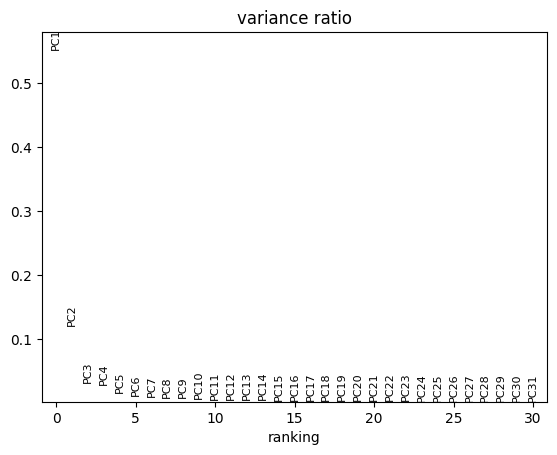

In [37]:
sc.pl.pca_variance_ratio(clustering.xenium_spot_data)

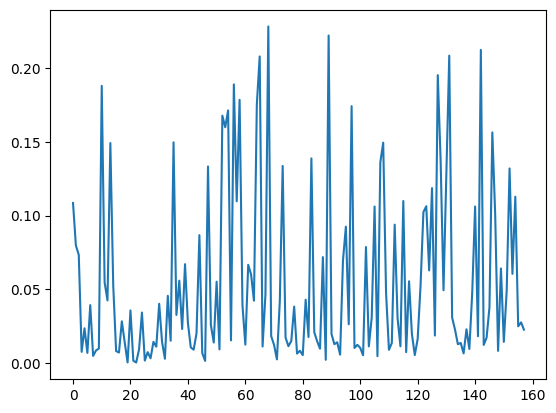

In [38]:
plt.plot(np.abs(clustering.xenium_spot_data.varm["PCs"][:, 0]))

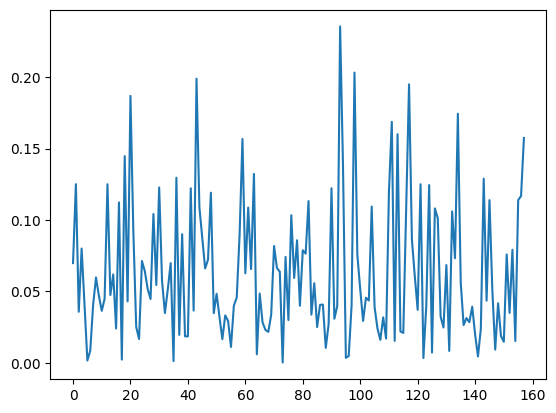

In [39]:
plt.plot(np.abs(clustering.xenium_spot_data.varm["PCs"][:, 1]))

In [40]:
clustering.xenium_spot_data.var

,highly_variable,means,dispersions,dispersions_norm
ABCC11,True,1.895555,2.518792,1.226907
ACTA2,True,2.650975,3.323530,1.228076
ACTG2,True,1.663738,2.295395,0.184020
ADGRE5,True,0.725112,1.116034,-0.397694
ADH1B,True,1.132153,2.384379,0.754093
...,...,...,...,...
TRIB1,True,1.852702,2.651511,1.509003
TUBA4A,True,2.046839,2.007675,-0.416338
VWF,True,1.584579,3.015977,1.348975
ZEB1,True,1.340439,1.370176,-0.430894


# EDA on Cell Data

In [41]:
cells = df_transcripts.groupby(['cell_id', 'feature_name']).size().reset_index(name='count')
cells_pivot = cells.pivot_table(index='cell_id', 
                                columns='feature_name', 
                                values='count', 
                                fill_value=0)
cells_pivot.shape

KeyboardInterrupt: 

In [ ]:
location_means = df_transcripts.groupby('cell_id').agg({
    'x_location': 'mean',
    'y_location': 'mean',
    'z_location': 'mean'
}).reset_index()

cells_pivot = location_means.join(cells_pivot, on='cell_id')

In [ ]:
# log normalization
cells_pivot.iloc[:, 4:] = np.log1p(cells_pivot.iloc[:, 4:])

In [ ]:
cells_pivot = cells_pivot[cells_pivot["cell_id"] != -1]

In [ ]:
cells_pivot.head()

,cell_id,x_location,y_location,z_location,ABCC11,ACTA2,ACTG2,ADAM9,ADGRE5,ADH1B,...,TUBA4A,TUBB2B,UCP1,USP53,VOPP1,VWF,WARS,ZEB1,ZEB2,ZNF562
1,1,1587.163466,1683.353685,15.503466,0.0,1.098612,0.000000,0.693147,0.000000,2.302585,...,0.000000,0.693147,0.0,1.791759,0.000000,0.000000,0.000000,0.693147,1.098612,0.000000
2,2,1650.407270,1514.410011,14.617333,0.0,0.000000,0.000000,0.693147,1.098612,0.693147,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.693147,2.197225,0.693147
3,3,1645.398455,1703.216616,16.257603,0.0,0.693147,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,1.098612,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,4,1664.134134,1506.358351,14.915675,0.0,1.386294,0.693147,0.000000,0.000000,1.386294,...,1.609438,0.000000,0.0,1.609438,0.693147,2.302585,1.609438,0.000000,1.609438,0.693147
5,5,1656.013911,1655.548640,16.786045,0.0,0.000000,0.000000,1.098612,0.000000,1.098612,...,0.000000,0.000000,0.0,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
random_cells = cells_pivot.sample(n=10000, random_state=1)  # random_state is used for reproducibility

In [ ]:
int(random_cells["x_location"].min()), int(random_cells["x_location"].max())


(572, 10017)

In [ ]:
int(random_cells["y_location"].min()), int(random_cells["y_location"].max())

(131, 8471)

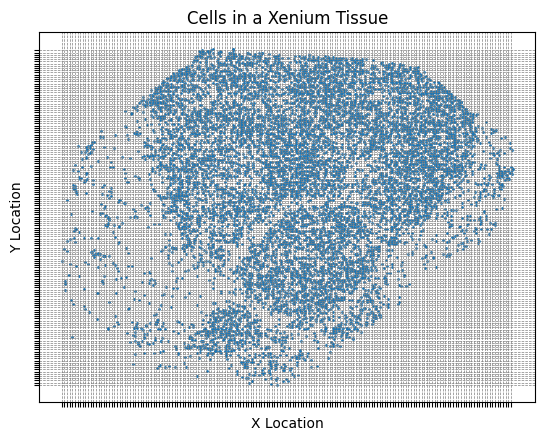

In [ ]:
plt.scatter(random_cells["x_location"], random_cells["y_location"], s=1)
plt.xlabel('X Location')
plt.ylabel('Y Location')
plt.title('Cells in a Xenium Tissue')


k = 55
plt.xticks(range(int(random_cells["x_location"].min()), int(random_cells["x_location"].max()) + 1, k), labels=[])
plt.yticks(range(int(random_cells["y_location"].min()), int(random_cells["y_location"].max()) + 1, k), labels=[])

plt.grid(True, which='both', color='gray', linewidth=0.5, linestyle='--')

plt.savefig("results/EDA/cells.png")

plt.show()

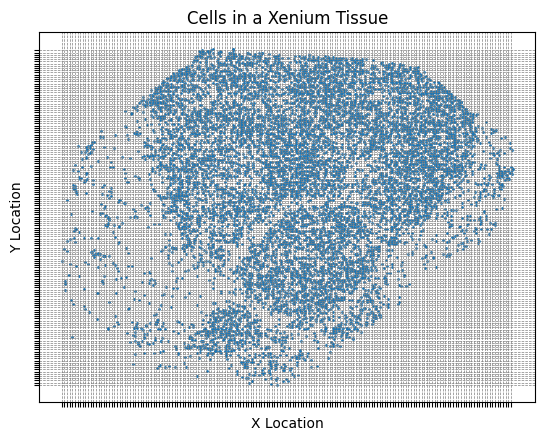

In [ ]:
plt.scatter(random_cells["x_location"], random_cells["y_location"], s=1)
plt.xlabel('X Location')
plt.ylabel('Y Location')
plt.title('Cells in a Xenium Tissue')


k = 55
plt.xticks(range(int(random_cells["x_location"].min()), int(random_cells["x_location"].max()) + 1, k), labels=[])
plt.yticks(range(int(random_cells["y_location"].min()), int(random_cells["y_location"].max()) + 1, k), labels=[])

plt.grid(True, which='both', color='gray', linewidth=0.5, linestyle='--')

plt.savefig("results/EDA/cells.png")

plt.show()

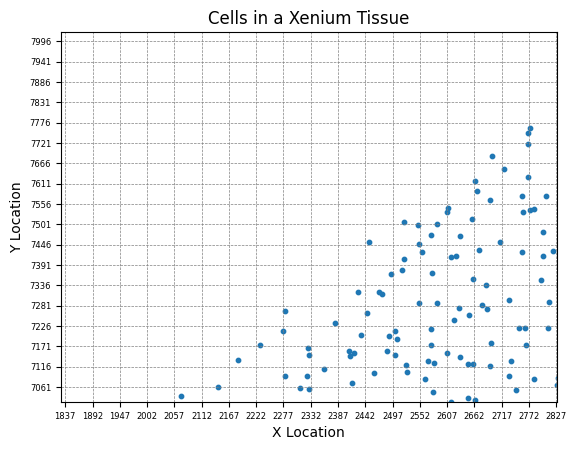

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'random_cells' is your DataFrame and it contains 'x_location' and 'y_location'

# Create scatter plot
plt.scatter(random_cells["x_location"], random_cells["y_location"], s=10)
plt.xlabel('X Location')
plt.ylabel('Y Location')
plt.title('Cells in a Xenium Tissue')

# Define the grid interval
k = 55
plt.xticks(range(int(random_cells["x_location"].min()), int(random_cells["x_location"].max()) + 1, k), fontsize=6)
plt.yticks(range(int(random_cells["y_location"].min()), int(random_cells["y_location"].max()) + 1, k), fontsize=6)

# Set gridlines
plt.grid(True, which='both', color='gray', linewidth=0.5, linestyle='--')

# Define the zoom area size
zoom_size = 1000  # Define how large the zoom area should be

# Select a random center point for the zoom
center_x = np.random.randint(2100, 2500)
center_y = np.random.randint(7000, random_cells["y_location"].max())

# Set the limits for the zoom area
plt.xlim(center_x - zoom_size / 2, center_x + zoom_size / 2)
plt.ylim(center_y - zoom_size / 2, center_y + zoom_size / 2)

plt.savefig("results/EDA/zoomed_cells.png")

# Show the plot with zoomed area
plt.show()


In [ ]:
pca = PCA(n_components=20)
pca.fit(cells_pivot.iloc[:, 4:])

PCA(n_components=20)

In [ ]:
np.set_printoptions(suppress=True)
print(np.round(pca.explained_variance_ratio_, 4))

[0.2441 0.06   0.0273 0.0232 0.0198 0.0174 0.012  0.0115 0.0109 0.0097
 0.0093 0.0086 0.008  0.0076 0.0074 0.007  0.0069 0.0066 0.0065 0.0064]


In [ ]:
cells_pivot.head()

,cell_id,x_location,y_location,z_location,ABCC11,ACTA2,ACTG2,ADAM9,ADGRE5,ADH1B,...,TUBA4A,TUBB2B,UCP1,USP53,VOPP1,VWF,WARS,ZEB1,ZEB2,ZNF562
1,1,1587.163466,1683.353685,15.503466,0.0,1.098612,0.000000,0.693147,0.000000,2.302585,...,0.000000,0.693147,0.0,1.791759,0.000000,0.000000,0.000000,0.693147,1.098612,0.000000
2,2,1650.407270,1514.410011,14.617333,0.0,0.000000,0.000000,0.693147,1.098612,0.693147,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.693147,2.197225,0.693147
3,3,1645.398455,1703.216616,16.257603,0.0,0.693147,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,1.098612,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,4,1664.134134,1506.358351,14.915675,0.0,1.386294,0.693147,0.000000,0.000000,1.386294,...,1.609438,0.000000,0.0,1.609438,0.693147,2.302585,1.609438,0.000000,1.609438,0.693147
5,5,1656.013911,1655.548640,16.786045,0.0,0.000000,0.000000,1.098612,0.000000,1.098612,...,0.000000,0.000000,0.0,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
genes = cells_pivot.iloc[:, 4:]
gene_dispersions = genes.var(axis=0) / (genes.mean(axis=0) ** 2)
gene_dispersions.sort_values(ascending=False)

PDCD1      405.738909
S100A8     290.419181
GNLY       209.690382
CTSG       157.251466
CD19       146.190599
              ...    
TACSTD2      0.377248
KRT7         0.347036
TOMM7        0.341501
TPD52        0.331611
GATA3        0.298791
Length: 280, dtype: float64

In [ ]:
gene_dispersions_proportions = (gene_dispersions / sum(gene_dispersions)).sort_values(ascending=False)
gene_dispersions_proportions

PDCD1      0.054154
S100A8     0.038762
GNLY       0.027987
CTSG       0.020988
CD19       0.019512
             ...   
TACSTD2    0.000050
KRT7       0.000046
TOMM7      0.000046
TPD52      0.000044
GATA3      0.000040
Length: 280, dtype: float64

In [ ]:
gene_dispersions_proportions.cumsum()

PDCD1      0.054154
S100A8     0.092916
GNLY       0.120903
CTSG       0.141892
CD19       0.161404
             ...   
TACSTD2    0.999824
KRT7       0.999870
TOMM7      0.999916
TPD52      0.999960
GATA3      1.000000
Length: 280, dtype: float64

In [ ]:
gene_dispersions_proportions[(gene_dispersions_proportions.cumsum() < 0.65)].index, len(gene_dispersions_proportions[(gene_dispersions_proportions.cumsum() < 0.65)].index)

(Index(['PDCD1', 'S100A8', 'GNLY', 'CTSG', 'CD19', 'OPRPN', 'TCL1A', 'KRT5',
        'UCP1', 'NCAM1', 'KRT6B', 'CEACAM8', 'CD79B', 'LILRA4', 'IL2RA', 'GZMK',
        'CD79A', 'MUC6', 'SCGB2A1', 'NDUFA4L2', 'MMP12', 'SPIB', 'CD80', 'NKG7',
        'LTB', 'MMP1', 'MZB1', 'CCL8', 'AVPR1A', 'PRF1', 'ESM1', 'TNFRSF17',
        'MS4A1', 'APOBEC3A', 'TIMP4', 'ADIPOQ', 'CCR7', 'CXCL5', 'HPX', 'FOXC2',
        'SNAI1', 'TPSAB1', 'SOX18', 'CLECL1', 'PDCD1LG2', 'FOXP3', 'CTLA4',
        'C5orf46', 'LAG3', 'CLEC9A', 'CD27', 'BANK1', 'HOXD9', 'IL3RA', 'KLRD1',
        'AQP3'],
       dtype='object'),
 56)

In [ ]:
gene_variances = genes.var(axis=0)
gene_variances = gene_variances.sort_values(ascending=False)
gene_var_proportions = (gene_variances / sum(gene_variances))
gene_var_proportions

GATA3       0.025460
SCD         0.024311
SERPINA3    0.024099
KRT7        0.022723
TACSTD2     0.021950
              ...   
UCP1        0.000116
OPRPN       0.000111
CD19        0.000105
S100A8      0.000089
PDCD1       0.000034
Length: 280, dtype: float64

In [ ]:
gene_var_proportions.cumsum()

GATA3       0.025460
SCD         0.049771
SERPINA3    0.073870
KRT7        0.096593
TACSTD2     0.118544
              ...   
UCP1        0.999661
OPRPN       0.999772
CD19        0.999877
S100A8      0.999966
PDCD1       1.000000
Length: 280, dtype: float64

In [ ]:
gene_var_proportions[(gene_var_proportions.cumsum() < 0.95)].index, len(gene_dispersions_proportions[(gene_var_proportions.cumsum() < 0.95)].index)

(Index(['GATA3', 'SCD', 'SERPINA3', 'KRT7', 'TACSTD2', 'TPD52', 'KRT23',
        'FOXA1', 'CCND1', 'ANKRD30A',
        ...
        'PRDM1', 'CYTIP', 'EGFR', 'KDR', 'AKR1C1', 'FCER1A', 'OXTR', 'CD163',
        'IL2RG', 'SSTR2'],
       dtype='object', length=176),
 176)